In [1]:
import gempy as gp
import numpy as np
%matplotlib inline

## Geological Model with just a Fault

In [2]:
# Create a model instance
geo_model = gp.create_model('no_dyke')

# Initialize the model, set dimension and load interface and orientation data
gp.init_data(geo_model, [0., 1200., 0., 1000., 0., 1500.], [100, 100, 100],
            path_i = '../data/07_Dyke_Model_3D_wo_Dyke_interfaces.csv',
            path_o = '../data/07_Dyke_Model_3D_wo_Dyke_orientations.csv');
#geo_model.set_topography??

Active grids: ['regular']


C:\Users\brigg\miniconda3\envs\env_gempy\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


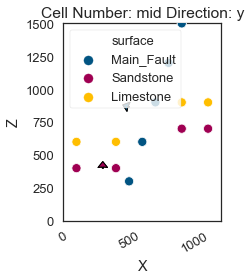

In [3]:
gp.plot_2d(geo_model, kwargs={"legend":False})

In [4]:
# Set the interpolator function
# Create the theano model
gp.set_interpolator(geo_model,
                         compile_theano=True,
                         theano_optimizer='fast_compile',
                         verbose=[]);

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                   values
range            2165.64
$C_o$             111667
drift equations   [3, 3]


In [6]:
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,Main_Fault,Default series,1,#015482,1
1,Sandstone,Default series,2,#9f0052,2
2,Limestone,Default series,3,#ffbe00,3
3,basement,Basement,1,#728f02,4


In [7]:
# Assign formations to series
gp.map_series_to_surfaces(geo_model,
                         {"Fault_series":'Main_Fault',
                         "Sediment_series":('Limestone', 'Sandstone')},
                         remove_unused_series=True)
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,Main_Fault,Fault_series,1,#015482,1
1,Sandstone,Sediment_series,1,#9f0052,2
2,Limestone,Sediment_series,2,#ffbe00,3
3,basement,Basement,1,#728f02,4


In [8]:
# Set Faults
geo_model.set_is_fault(['Fault_series'],
                      change_color=False);

In [9]:
# Compute the model
sol = gp.compute_model(geo_model, compute_mesh=True)

C:\Users\brigg\miniconda3\envs\env_gempy\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


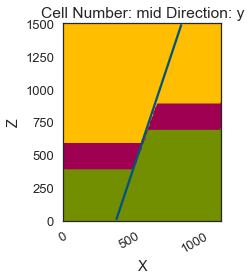

In [10]:
gp.plot_2d(geo_model, direction='y', show_block=True, show_boundaries=True, 
           show_data=False, show_results=True)

## Introducing a Dyke to try to act as a Fault body

In [11]:
# Create a model instance
model_dyke = gp.create_model('with_dyke')

# Initialize the model, set dimension and load interface and orientation data
gp.init_data(model_dyke, [0., 1200., 0., 1000., 0., 1500.], [100, 100, 100],
            path_i = '../data/07_Dyke_Model_Dyke_interfaces.csv',
            path_o = '../data/07_Dyke_Model_Dyke_orientations.csv');

Active grids: ['regular']


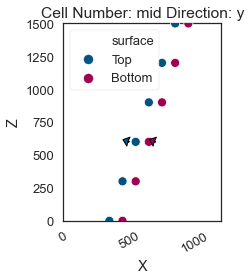

In [12]:
gp.plot_2d(model_dyke)

In [13]:
# Assign formations to series
gp.map_series_to_surfaces(model_dyke,
                         {"Sed_series": ('Top', 'Bottom')},
                         remove_unused_series=True)
model_dyke.surfaces

,surface,series,order_surfaces,color,id
0,Top,Sed_series,1,#015482,1
1,Bottom,Sed_series,2,#9f0052,2
2,basement,Basement,1,#ffbe00,3


In [14]:
# Set the interpolator function
# Create the theano model
gp.set_interpolator(model_dyke,
                         compile_theano=True,
                         theano_optimizer='fast_compile',
                         verbose=[]);

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                   values
range            2165.64
$C_o$             111667
drift equations   [3, 3]


In [15]:
# Compute the model
sol_dyke = gp.compute_model(model_dyke, compute_mesh=True)

C:\Users\brigg\miniconda3\envs\env_gempy\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


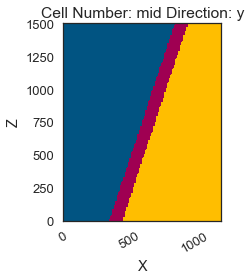

In [16]:
gp.plot_2d(model_dyke, direction='y', show_block=True, show_boundaries=False, 
           show_data=False, show_results=True)

## Combine both models
Using a hierarchical modeling approach, we can combine both models and generate a final 3D model with a fault core or dyke.

In [18]:
# We want to know where the model result voxels have the ID 2, which reflects the red layer in the plot above.
inds = np.where(sol_dyke.lith_block==2.)

# then we assign to these indices a new value, e.g. 5. Important: It has to be different than the present values
# to don't mess with the previous base model, we copy the lith_block from it
cp_sol_lith_block = np.copy(sol.lith_block)

# and assign the value 5. to the indices with value 2. in the dyke model
cp_sol_lith_block[inds] = 5.

In [19]:
# Then we reshape the array to the model grid
nx, ny, nz = geo_model.grid.regular_grid.resolution
resh_block = np.reshape(cp_sol_lith_block, (nx, ny, nz), order='F')

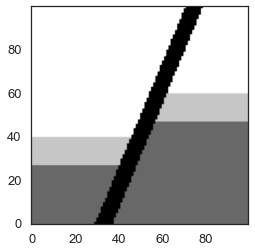

In [21]:
import matplotlib.pyplot as plt
plt.imshow(resh_block[:,50,:], origin='lower')

## Backup try to directly add this to the current model

In [37]:
sol.lith_block[inds] = 5.

C:\Users\brigg\miniconda3\envs\env_gempy\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


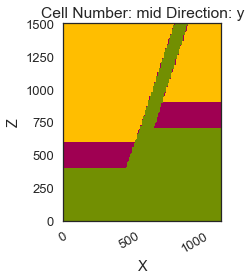

In [38]:
gp.plot_2d(geo_model, direction='y', show_block=True, show_boundaries=False, 
           show_data=False, show_results=True)

In [40]:
gp.plot_3d(geo_model, plotter_type='background', show_surfaces=False, show_lith=True)